In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
train_test_split
from sklearn.tree import DecisionTreeClassifier
import dice_ml
from dice_ml.utils import helpers # helper functions
from dice_ml import Data,Model,Dice
import numpy as np
from xgboost import XGBClassifier



c:\Users\praskulkarni\AppData\Local\miniconda3\Lib\site-packages\dice_ml\utils\exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [2]:
dataframe_heart_disease = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

dataframe_heart_disease =  dataframe_heart_disease.dropna()
dataframe_heart_disease = dataframe_heart_disease[dataframe_heart_disease['chol'] !=0]
dataframe_heart_disease = dataframe_heart_disease[dataframe_heart_disease['trestbps'] !=0]

In [3]:
# Split the data into features and target label
y = dataframe_heart_disease.target
X = dataframe_heart_disease.drop(['target'], axis=1)

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical = X_train.columns.difference(numerical)

In [6]:
categorical

Index(['cp', 'exang', 'fbs', 'restecg', 'sex', 'slope'], dtype='object')

In [7]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])


'''transformations = ColumnTransformer(
    transformers=[('num', numeric_transformer, numerical)])'''

"transformations = ColumnTransformer(\n    transformers=[('num', numeric_transformer, numerical)])"

In [8]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', DecisionTreeClassifier())])
dt_model = clf.fit(X_train, y_train)


In [11]:
param_grid = {
    'classifier__max_depth': [2, 3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


In [12]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(dt_model, param_grid=param_grid)
grid_search.fit(X_train, y_train)


# Print the best parameters and the score on the test set
print("Best parameters: ", grid_search.best_params_)
print("Test set score: ", grid_search.score(X_test, y_test))

Best parameters:  {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Test set score:  0.8186274509803921


In [13]:
# create the pipeline with the XGBClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', transformations),
    ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2))
])


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the training and test data
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

import pandas as pd

# Compute various classification metrics
metrics = {
    'Accuracy': [accuracy_score(y_train, train_preds), accuracy_score(y_test, test_preds)],
    'Precision': [precision_score(y_train, train_preds), precision_score(y_test, test_preds)],
    'Recall': [recall_score(y_train, train_preds), recall_score(y_test, test_preds)],
    'F1 Score': [f1_score(y_train, train_preds), f1_score(y_test, test_preds)],
    'ROC AUC Score': [roc_auc_score(y_train, train_preds), roc_auc_score(y_test, test_preds)]
}

# Create a DataFrame from the metrics
df_metrics = pd.DataFrame(metrics, index=['Train', 'Test'])

df_metrics.to_clipboard()

# Print the DataFrame
print(df_metrics)

       Accuracy  Precision    Recall  F1 Score  ROC AUC Score
Train  0.905405   0.873737  0.927614  0.899870       0.907118
Test   0.794118   0.816327  0.769231  0.792079       0.794615


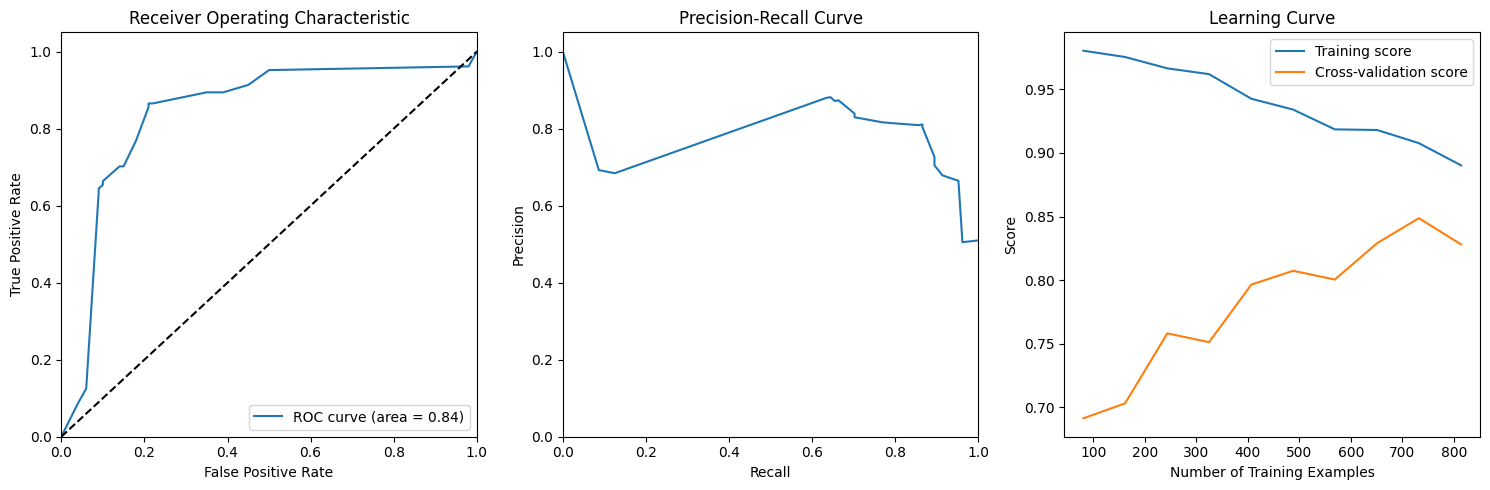

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import learning_curve

# Assuming pipeline is your trained classifier and X_test is your test data
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Create a 1 by 3 grid of plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the ROC curve
ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

# Plot the Precision-Recall curve
ax2.plot(recall, precision)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

# Plot the learning curve
ax3.plot(train_sizes, train_mean, label='Training score')
ax3.plot(train_sizes, test_mean, label='Cross-validation score')
ax3.set_xlabel('Number of Training Examples')
ax3.set_ylabel('Score')
ax3.set_title('Learning Curve')
ax3.legend(loc='best')

# Display the plots
plt.tight_layout()
plt.show()

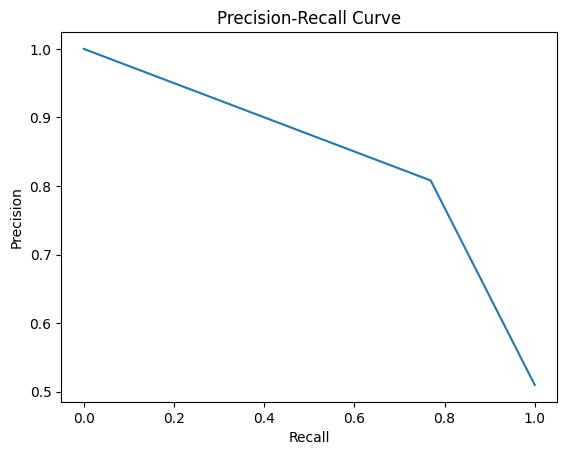

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
test_preds = pipeline.predict(X_test)

# Compute the precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, test_preds)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

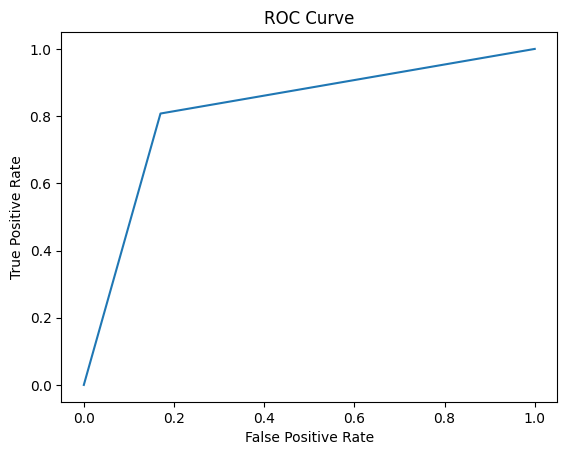

In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
test_preds = pipeline.predict(X_test)

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, test_preds)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

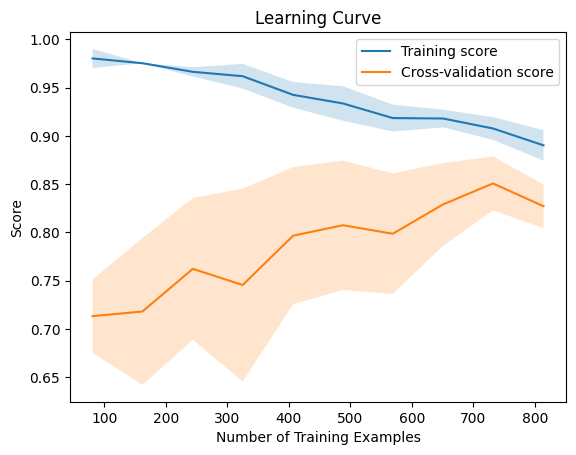

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Define the number of training examples to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=5)

# Compute the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.title('Learning Curve')
plt.xlabel('Number of Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

In [12]:
{'chol': 0.9764865197587098, 'thalach': 0.9347531700110796, 'age': 0.9297057737289179, 'trestbps': 0.8015511510525668, 'oldpeak': 0.44897205465960854, 'cp': 0.3046903853256186, 'restecg': 0.2611104271820756, 'slope': 0.19389388157084822, 'sex': 0.13997291641019327, 'exang': 0.12310722639418933, 'fbs': 0.11338175550904839}


{'chol': 0.9764865197587098,
 'thalach': 0.9347531700110796,
 'age': 0.9297057737289179,
 'trestbps': 0.8015511510525668,
 'oldpeak': 0.44897205465960854,
 'cp': 0.3046903853256186,
 'restecg': 0.2611104271820756,
 'slope': 0.19389388157084822,
 'sex': 0.13997291641019327,
 'exang': 0.12310722639418933,
 'fbs': 0.11338175550904839}

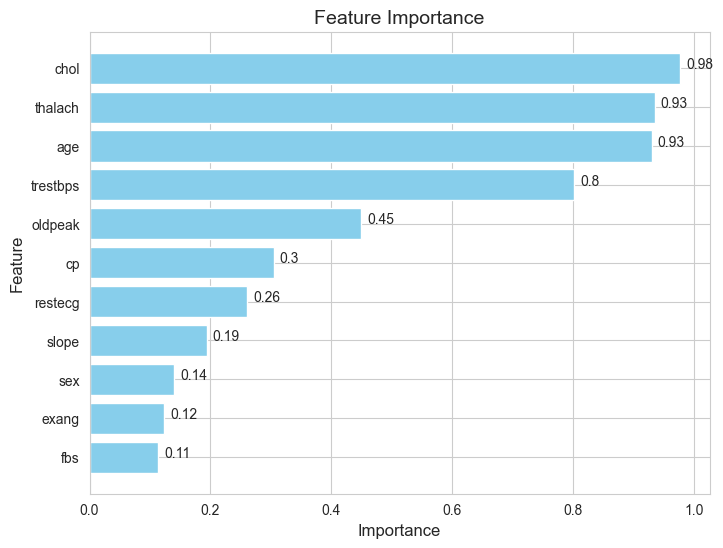

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dictionary
data = {
    'chol': 0.9764865197587098,
    'thalach': 0.9347531700110796,
    'age': 0.9297057737289179,
    'trestbps': 0.8015511510525668,
    'oldpeak': 0.44897205465960854,
    'cp': 0.3046903853256186,
    'restecg': 0.2611104271820756,
    'slope': 0.19389388157084822,
    'sex': 0.13997291641019327,
    'exang': 0.12310722639418933,
    'fbs': 0.11338175550904839
}

# Set the figure size and style
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')

# Create a horizontal bar chart
plt.barh(list(data.keys()), list(data.values()), align='center', color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()

# Add annotations to the bars
for i, v in enumerate(data.values()):
    plt.text(v + 0.01, i, str(round(v, 2)), fontsize=10)

# Show the plot
plt.show()

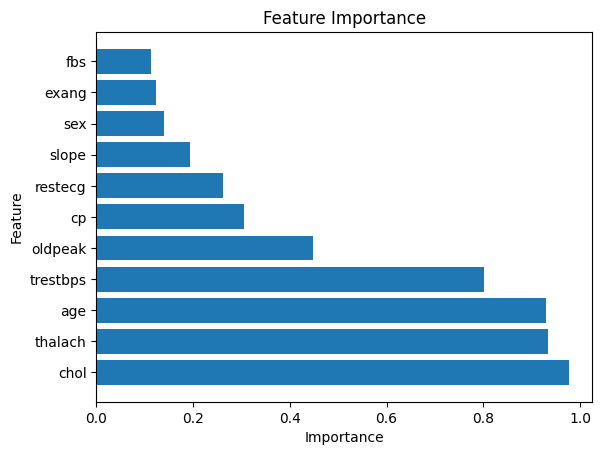

In [13]:
import matplotlib.pyplot as plt

# Define the dictionary
data = {'chol': 0.9764865197587098, 'thalach': 0.9347531700110796, 'age': 0.9297057737289179, 'trestbps': 0.8015511510525668, 'oldpeak': 0.44897205465960854, 'cp': 0.3046903853256186, 'restecg': 0.2611104271820756, 'slope': 0.19389388157084822, 'sex': 0.13997291641019327, 'exang': 0.12310722639418933, 'fbs': 0.11338175550904839}

# Create a horizontal bar chart
plt.barh(range(len(data)), list(data.values()), align='center')
plt.yticks(range(len(data)), list(data.keys()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [17]:
# train the model on the entire training set
xgb_pipeline = pipeline.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)


In [18]:
X_high_risk_tp = X_test[(y_pred == 1) & (y_test == 1)].reset_index().drop(['index'], axis=1)

In [19]:
train_data = pd.concat([X_train, y_train], axis=1)


# Create a DICE data object
d = Data(dataframe=pd.DataFrame(train_data, columns=dataframe_heart_disease.columns), continuous_features=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],outcome_name='target')

# Create a DICE model object
m = Model(model=xgb_pipeline, backend="sklearn")

In [44]:
test_instance = X_high_risk_tp[10:11]


In [45]:
# Create a DICE explainer object and generate an explanation

exp_dice = Dice(d, m,method='genetic').generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                            features_to_vary=["trestbps", "chol", "thalach"],permitted_range={"trestbps": [80,120],
                                                            "chol": [150, 200],
                                                            "thalach": [120, 220 - test_instance['age'].values[0]]}
                                                            )
 
# Print the explanation
print(exp_dice.visualize_as_dataframe())



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

Query instance (original outcome : 1)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,69.0,1,4,145.0,289.0,1,1,110.0,1,1.8,2,1



Diverse Counterfactual set (new outcome: 0)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,69.0,1,4,120.0,196.0,1,1,147.0,1,1.8,2,0
0,69.0,1,4,120.0,172.0,1,1,151.0,1,1.8,2,0
0,69.0,1,4,118.0,182.0,1,1,149.0,1,1.8,2,0
0,69.0,1,4,118.0,179.0,1,1,149.0,1,1.8,2,0
0,69.0,1,4,120.0,162.0,1,1,151.0,1,1.8,2,0
0,69.0,1,4,117.0,176.0,1,1,151.0,1,1.8,2,0
0,69.0,1,4,110.0,194.0,1,1,142.0,1,1.8,2,0
0,69.0,1,4,110.0,172.0,1,1,142.0,1,1.8,2,0
0,69.0,1,4,110.0,172.0,1,1,142.0,1,1.8,2,0
0,69.0,1,4,113.0,175.0,1,1,150.0,1,1.8,2,0


None


In [27]:
# Create a DICE explainer object and generate an explanation
'''
exp = Dice(d, m,method = "genetic").generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                            features_to_vary=["trestbps", "chol", "thalach"],algorithm = "DiverseCF",feature_weights="inverse_mad",permitted_range = {"trestbps": [80, test_instance['trestbps'].values[0]-1], "chol": [100, test_instance['chol'].values[0]-1], "thalach": [70,220- test_instance['age'].values[0]]},
                                                            proximity_weight=2,diversity_weight=3, sparsity_weight = 2,posthoc_sparsity_algorithm="binary",posthoc_sparsity_param =0.1,maxiterations=10)
 
# Print the explanation
print(exp.visualize_as_dataframe())'''


'\nexp = Dice(d, m,method = "genetic").generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",\n                                                            features_to_vary=["trestbps", "chol", "thalach"],algorithm = "DiverseCF",feature_weights="inverse_mad",permitted_range = {"trestbps": [80, test_instance[\'trestbps\'].values[0]-1], "chol": [100, test_instance[\'chol\'].values[0]-1], "thalach": [70,220- test_instance[\'age\'].values[0]]},\n                                                            proximity_weight=2,diversity_weight=3, sparsity_weight = 2,posthoc_sparsity_algorithm="binary",posthoc_sparsity_param =0.1,maxiterations=10)\n \n# Print the explanation\nprint(exp.visualize_as_dataframe())'

In [69]:
from joblib import Parallel, delayed

df_no_counterfactuals = pd.DataFrame(columns=X_high_risk.columns)

# Define a function to generate a single counterfactual example
def generate_cf(test_instance):
    try:
        return Dice(d, m, method="genetic").generate_counterfactuals(test_instance, total_CFs=1, desired_class="opposite",
                                                                     features_to_vary=["trestbps", "chol", "thalach"],
                                                                     permitted_range={"trestbps": [80,120],
                                                                                      "chol": [150, 200],
                                                                                      "thalach": [120, 220 - test_instance['age'].values[0]]},
                                                                     maxiterations=10)
    except Exception as e:
        print("No counterfactuals found for test instance:", test_instance)
        df_no_counterfactuals.append(test_instance)
        return None

# Generate counterfactual examples in parallel using joblib
num_cores = 8  # Set the number of CPU cores to use
results = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(5))

# Print the explanations
for exp in results:
    if exp is not None:
        print(exp.visualize_as_dataframe())


All Countefactuals Found

In [86]:
def generate_cf(test_instance):
    try:
        return Dice(d, m,method='genetic').generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                            features_to_vary=["trestbps", "chol", "thalach"],
                                                            diversity_weight = 5, proximity_weight = 2, sparsity_weight = 5   
                                                            #permitted_range={"trestbps": [80,120],  "chol": [100, 200], "thalach": [70, 220 - test_instance['age'].values[0]]},
                                                            )
 
    except Exception as e:
        print("No counterfactuals found for test instance:", test_instance)
        df_no_counterfactuals.append(test_instance)
        return None

With Ideal Constraints

In [72]:
def generate_cf(test_instance):
    try:
        return Dice(d, m,method='genetic').generate_counterfactuals(test_instance, total_CFs=1, desired_class="opposite",
                                                            features_to_vary=["trestbps", "chol", "thalach"],
                                                            diversity_weight = 5, proximity_weight = 2, sparsity_weight = 5,  
                                                            permitted_range={"trestbps": [80,120],  "chol": [150, 200], "thalach": [120, 220 - test_instance['age'].values[0]]}
                                                            )
 
    except Exception as e:
        print("No counterfactuals found for test instance:", test_instance)
        df_no_counterfactuals.append(test_instance)
        return None

With Feasible Constraints

In [85]:
def generate_cf(test_instance):
    try:
        return Dice(d, m,method='genetic').generate_counterfactuals(test_instance, total_CFs=1, desired_class="opposite",
                                                            features_to_vary=["trestbps", "chol", "thalach"],
                                                            diversity_weight = 5, proximity_weight = 2, sparsity_weight = 5,  
                                                            permitted_range={"trestbps": [80, test_instance['trestbps'].values[0]-10],
                                                                                    "chol": [100, test_instance['chol'].values[0]-0.1*test_instance['chol'].values[0]],
                                                                                    "thalach": [120, 220 - test_instance['age'].values[0]]}
                                                            )
 
    except Exception as e:
        print("No counterfactuals found for test instance:", test_instance)
        df_no_counterfactuals.append(test_instance)
        return None

Finding CF's

In [87]:
exps_ = []
num_cores = -1
df_no_counterfactuals = pd.DataFrame(columns=X_high_risk_tp.columns)
# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk_tp)):
    test_instance = X_high_risk_tp.iloc[[i]]
    print(i)
    #exp = generate_cf(test_instance)
    # Generate counterfactual examples in parallel using joblib
    #num_cores = 8  # Set the number of CPU cores to use
    exp = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(1))
    exps_.append(exp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


In [88]:
df_no_counterfactuals = X_high_risk_tp.loc[[exp[0] is None for exp in exps_]]

In [89]:
df_no_counterfactuals

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope


In [125]:
test_instance = X_high_risk[45:46]

In [127]:
test_instance

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
45,60,1,4,130,186,1,1,140,1,0.5,2


In [137]:
imp = Dice(d, m,method='genetic').local_feature_importance(test_instance, posthoc_sparsity_param=None)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


In [138]:
imp.local_importance

[{'age': 1.0,
  'thalach': 1.0,
  'oldpeak': 1.0,
  'trestbps': 0.9,
  'chol': 0.8,
  'fbs': 0.3,
  'restecg': 0.3,
  'exang': 0.2,
  'cp': 0.1,
  'sex': 0.0,
  'slope': 0.0}]

In [140]:
cobj = Dice(d, m,method='genetic').global_feature_importance(X_train, total_CFs=10, posthoc_sparsity_param=None)
print(cobj.summary_importance)

  0%|          | 0/814 [00:00<?, ?it/s]

100%|██████████| 814/814 [53:40<00:00,  3.96s/it]  


{'chol': 0.9764865197587098, 'thalach': 0.9347531700110796, 'age': 0.9297057737289179, 'trestbps': 0.8015511510525668, 'oldpeak': 0.44897205465960854, 'cp': 0.3046903853256186, 'restecg': 0.2611104271820756, 'slope': 0.19389388157084822, 'sex': 0.13997291641019327, 'exang': 0.12310722639418933, 'fbs': 0.11338175550904839}


In [129]:
xgb_pipeline.predict(test_instance)

array([1])

In [128]:
# Generate counterfactual examples in parallel using joblib
num_cores = 8  # Set the number of CPU cores to use
results = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(5))

# Print the explanations
for exp in results:
    if exp is not None:
        print(exp.visualize_as_dataframe())

KeyboardInterrupt: 

In [23]:
from joblib import Parallel, delayed

# Define a function to generate a single counterfactual example
def generate_cf(test_instance):
   
    return Dice(d, m, method="genetic").generate_counterfactuals(test_instance, total_CFs=1, desired_class="opposite",
                                                                    features_to_vary=["trestbps", "chol", "thalach"],
                                                                    permitted_range={"trestbps": [80,120],
                                                                                    "chol": [100, 200],
                                                                                    "thalach": [70, 220 - test_instance['age'].values[0]]},
                                                                    maxiterations=100)

# Generate counterfactual examples in parallel using joblib
num_cores = 8  # Set the number of CPU cores to use
results = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(5))

# Print the explanations
for exp in results:
    print(exp.visualize_as_dataframe())

UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

In [ ]:
from joblib import Parallel, delayed
import pandas as pd
# Generate counterfactual examples in parallel using joblib
num_cores = 8  # Set the number of CPU cores to use
# Define a function to generate a single counterfactual example
def generate_cf(test_instance):
    try:
        print("finding counterfactuals with permitted range...")
        return Dice(d, m, method="genetic").generate_counterfactuals(test_instance, total_CFs=1, desired_class="opposite",
                                                                     features_to_vary=["trestbps", "chol", "thalach"],
                                                                     permitted_range={"trestbps": [80, test_instance['trestbps'].values[0]-1],
                                                                                      "chol": [100, test_instance['chol'].values[0]-1],
                                                                                      "thalach": [70, 220 - test_instance['age'].values[0]]},
                                                                     proximity_weight=10,diversity_weight=2, sparsity_weight = 2,posthoc_sparsity_algorithm="binary",posthoc_sparsity_param =0.1,
                                                                     maxiterations=100)
    except Exception as e:
        print("No counterfactuals found with permitted range. Generating counterfactuals without permitted range...")
        return Dice(d, m, method="genetic").generate_counterfactuals(test_instance, total_CFs=1 , desired_class="opposite",
                                                                     features_to_vary=["trestbps", "chol", "thalach"],proximity_weight=10,diversity_weight=2, sparsity_weight = 2,posthoc_sparsity_algorithm="binary",posthoc_sparsity_param =0.1,
                                                                     maxiterations=10)


results = Parallel(n_jobs=num_cores)(delayed(generate_cf)(test_instance) for i in range(20))

# Merge the explanations into one dataframe
df = pd.concat([exp.cf_examples_list[0].final_cfs_df for exp in results]).drop_duplicates()

# Print the merged dataframe


In [21]:
# Create a DICE explainer object and generate an explanation

exp = Dice(d, m,method='genetic').generate_counterfactuals(test_instance, total_CFs=20, desired_class="opposite",
                                                            features_to_vary=["trestbps", "chol", "thalach"],permitted_range = {"trestbps": [80, 120], "chol": [100, 200], "thalach": [70,220- test_instance['age'].values[0]]}
                                                           )
 
# Print the explanation
print(exp.visualize_as_dataframe())


  0%|          | 0/1 [41:27<?, ?it/s]


KeyboardInterrupt: 

In [21]:
# Load the dataset and create a machine learning model
# ...

# Create a Dice explainer object with the Genetic method
dice = Dice(d, m, method='genetic')

exps_ = []

# Iterate over each instance of X_high_risk and generate counterfactuals
for i in range(len(X_high_risk)):
    test_instance = X_high_risk.iloc[[i]]
    try:
        exp = dice.generate_counterfactuals(test_instance, total_CFs=5, desired_class="opposite",
                                            features_to_vary=["trestbps", "chol", "thalach"], 
                                            permitted_range={"trestbps": [80, 130],
                                                            "chol": [100,200],
                                                            "thalach": [70, 220 - test_instance['age'].values[0]]},
                                            maxiterations=100)
    except Exception as e:
        exp =  Dice(d, m, method="genetic").generate_counterfactuals(test_instance, total_CFs=5, desired_class="opposite",
                                                                     features_to_vary=["trestbps", "chol", "thalach"],
                                                                     maxiterations=100)
        
    # Print the explanation
    print(f"Counterfactuals for instance {i}:")
    #print(exp.visualize_as_dataframe())
    exps_.append(exp)

100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Counterfactuals for instance 0:


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Counterfactuals for instance 1:


100%|██████████| 1/1 [00:32<00:00, 32.02s/it]


Counterfactuals for instance 2:


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Counterfactuals for instance 3:


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Counterfactuals for instance 4:


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Counterfactuals for instance 5:


100%|██████████| 1/1 [05:34<00:00, 334.30s/it]


Counterfactuals for instance 6:


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Counterfactuals for instance 7:


  0%|          | 0/1 [1:53:43<?, ?it/s]


KeyboardInterrupt: 

In [51]:
exp_dice

In [24]:

exp_dfs = exp_dice.cf_examples_list[0].final_cfs_df

In [25]:
exp_dfs.drop(['target'], axis=1, inplace=True)

In [26]:
xgb_pipeline.predict(exp_dfs)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
test_instance['target'] = 1

C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_20456\99395437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_instance['target'] = 1


In [28]:
chol_test = test_instance['chol'].values[0]
tres_test = test_instance['trestbps'].values[0]
thalach_test = test_instance['thalach'].values[0]

In [29]:
feasible_counterfactuals = exp_dfs[((exp_dfs['thalach'] > thalach_test) & (exp_dfs['thalach']< 220 - exp_dfs['age'])) & (exp_dfs['chol'] < chol_test) & (exp_dfs['trestbps'] < tres_test)]

For subjects with cholestestoral in range … and have target=0, their target would be 1 if cholesterol were greater than …
For subjects with cholesterol in range … and thalac in range … and target = 0, their target would be 1 if cholesterol were in range …. thalac were in range …
Monotonicity
Shape of the Curve between variables 
Cholestrol can either increase the chance or it has no effect
(Constrained XgBoost, Normalizing flows,Linear Models)

In [30]:
exp_dfs['target']=0

In [31]:
fact_and_counterfactual = pd.concat([test_instance,exp_dfs])

In [32]:
fact_and_counterfactual

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,59.0,1,1,160.0,273.0,0,2,125.0,0,0.0,1,1
0,59.0,1,1,106.0,176.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,105.0,176.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,105.0,173.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,103.0,180.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,102.0,185.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,100.0,182.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,100.0,182.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,100.0,178.0,0,2,125.0,0,0.0,1,0
0,59.0,1,1,100.0,175.0,0,2,125.0,0,0.0,1,0
